# kNN（k最近傍法）

入力$\boldsymbol{x}^{\text{test}}$に最も近い$k$個の訓練データ$\boldsymbol{x}_1^{\text{train}}, \dots, \boldsymbol{x}_k^{\text{train}}$のサンプルの平均を使って予測するシンプルな機械学習アルゴリズム

## 例

以下のデータを例として使う

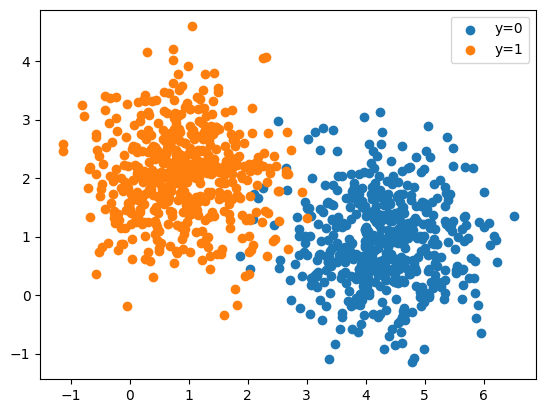

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs
n_samples = 1000
n_classes = 2
X, y = make_blobs(n_samples=n_samples, centers=n_classes, cluster_std=0.8, random_state=0)
X = X[:, ::-1]

fig, ax = plt.subplots()
for label in np.unique(y):
    idx = y == label
    ax.scatter(X[idx, 0], X[idx, 1], label=f"y={label}")
ax.legend()
fig.show()

予測の処理は、ユークリッド距離

$$
d(\boldsymbol{x}^{\text{test}}, \boldsymbol{x}_i^{\text{train}}) = \| \boldsymbol{x}^{\text{test}} - \boldsymbol{x}_i^{\text{train}} \|
$$

を個々のデータ点同士について計算して$k$個の近傍点で平均をとることにする。

計算量を考えると、本当はKDTreeなどの高速な最近傍探索アルゴリズムを使ったほうがよい。

In [2]:
k = 10
X_train = X
y_train = y

def predict(x_test: np.array) -> int:
    # testのデータ点と訓練データの点の距離
    distances = np.linalg.norm(X_train - x_test, axis=1)
    neighbors_idx = np.argsort(distances)[:k]
    neighbors = y_train[neighbors_idx]
    proba = np.mean(neighbors)
    y_pred = 1 * (proba >= 0.5)
    return y_pred

識別境界を簡単に確認してみる。格子状に点をとって判別結果を描く方法をとってみる。

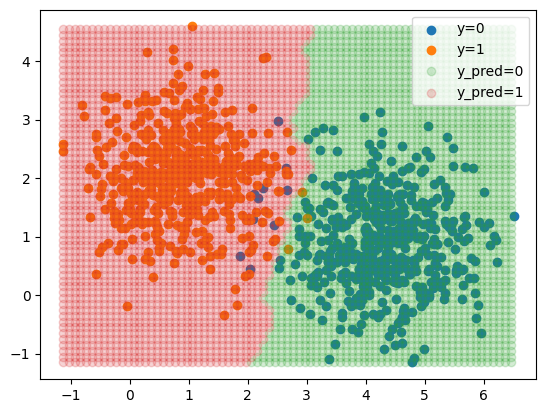

In [3]:
# 識別境界を簡単に描画

# 格子状のデータ点
import numpy as np
from itertools import product

x0 = np.arange(X[:, 0].min(), X[:, 0].max(), 0.1)
x1 = np.arange(X[:, 1].min(), X[:, 1].max(), 0.1)
X_grid = np.array(list(product(x0, x1)))

# 予測
y_pred = np.array([predict(x) for x in X_grid])

# plot
fig, ax = plt.subplots()
# datapoints
for label in np.unique(y):
    idx = y == label
    ax.scatter(X[idx, 0], X[idx, 1], label=f"y={label}")

# prediction
for label in np.unique(y_pred):
    idx = y_pred == label
    ax.scatter(X_grid[idx, 0], X_grid[idx, 1], label=f"y_pred={label}", alpha=0.2)
ax.legend()
fig.show()

## k=0の最近傍法

仮想的に$k=0$と置いた0近傍法が理論上の最適レートを達成するらしい。

モンテカルロ・シミュレーションでバイアスとバリアンスを測ると、$k$を大きくするほどバリアンスは小さくなるがバイアスは大きくなるトレードオフがある。$k$がゼロに近くなるとバリアンスは非常に大きくなるがバイアスは小さくなる。

:::{admonition} 仮想的な0近傍推定量

ユーザーが指定する$1 \leq k_1 < k_2 < \cdots < k_V \leq n$を用いて

1. 各 $k_v$ について $k$ 近傍推定量 $\hat{\eta}_{k_v}^{(k N N)}$ を計算
2. 各 $k_v$ について距離 $r_{k_v}:=\left\|x_{\left(k_v\right)}-x_*\right\|_2$ を計算
3. 回帰関数 $f_\theta\left(r_{k_v}\right)$ により, $r_{k_v}$ を介して $k_v$ 近傍推定量を予測する：

$$
\hat{\theta}:=\underset{\theta \in \Theta}{\arg \min } \sum_{v=1}^V\left\{\hat{\eta}_{k_v}^{(k \mathrm{NN})}-f_\theta(r_{k_v})\right\}^2
$$

4. $r_0=0$ に外挿した $f_{\hat{\theta}}(0)$ を特に「マルチスケール $k$ 近傍推定量」と呼び、 これが仮想的な0近傍推定量に相当する。
:::

$C=\max \{\gamma \in \mathbb{N} \cup\{0\} \mid \gamma < \beta / 2\}$ とした多項式関数

$$
f_\theta(r)=\theta_0+\theta_1 r^2+\theta_2 r^4+\cdots+\theta_C r^{2 C}
$$

を回帰関数として用いると、仮想的な0近傍推定量は高次のバイアスを補正し、最適レートを達成することが証明できる。 さらにプラグイン型の分類器 $\mathbb{1}(\hat{\eta}(X_*) \geq 1 / 2)$ を用いると分類問題における最適レートを達成する (Okuno and Shimodaira (2020) Theorem 2)

### 重み付き近傍法との関係

仮想的な0近傍推定量は重み付き近傍法

$$
\hat{\eta}_{k, \boldsymbol{w}}^{(k \mathrm{NN})}\left(X_*\right)=\sum_{i=1}^k w_i y_{(i)}
$$

として考えることができる。

:::{card} 参考

- [論文解説：仮想的な0近傍法による高次バイアス補正 | Jxiv](https://jxiv.jst.go.jp/index.php/jxiv/preprint/view/945)
- [Okuno, A., & Shimodaira, H. (2020). Extrapolation towards imaginary 0-nearest neighbour and its improved convergence rate. Advances in Neural Information Processing Systems, 33, 21889-21899.](https://papers.nips.cc/paper/2020/hash/f9028faec74be6ec9b852b0a542e2f39-Abstract.html)
:::

### 試してみる

モンテカルロ・シミュレーションでkごとの予測値の平均と標準偏差を見る

たしかに、論文中にあったような図になる。kが小さいほうがbiasは小さい傾向がある

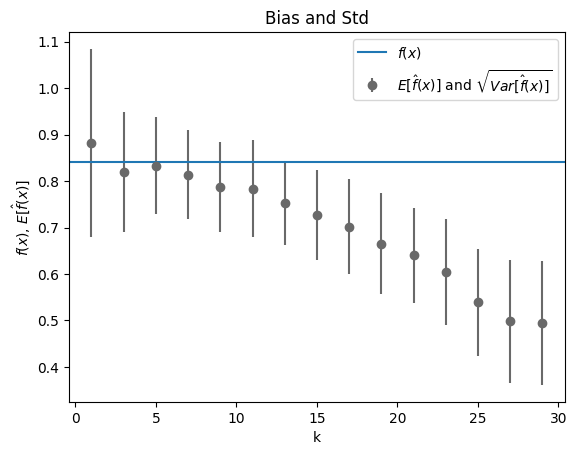

In [8]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
np.random.seed(0)

# x = 1のデータ点をtestとする
x = np.array([1])
y_true = np.sin(x)
X_true = x.reshape(-1, 1)

def gen_sample(n):
    x = np.random.uniform(-3, 3, size=n)
    irreducible_error = np.random.normal(0, 0.2, n)
    y = np.sin(x) + irreducible_error
    X = x.reshape(-1, 1)
    return X, y

n_iter = 100  # シミュレーションの繰り返し数
n = 50  # 訓練データの数
results = []
for k in range(1, 31, 2):
    preds = []
    for i_iter in range(n_iter):
        X_train, y_train = gen_sample(n=n)
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_true)
        preds.append(y_pred[0])

    y_hat_mean = np.mean(preds)
    bias = y_true[0] - np.mean(preds)
    results.append({"k": k, "mean_pred": y_hat_mean, "bias": bias, "variance": np.var(preds)})

# Plot
fig, ax = plt.subplots()
for i, result in enumerate(results):
    k = result["k"]
    label = r"$E[\hat{f}(x)]$ and $\sqrt{Var[\hat{f}(x)]}$" if i == 0 else None
    ax.errorbar(k, result["mean_pred"], yerr=np.sqrt(result["variance"]), fmt='o', color="dimgray", label=label)
ax.axhline(y_true, label=r"$f(x)$")
ax.legend()
ax.set(xlabel="k", ylabel="$f(x)$, $E[\hat{f}(x)]$", title="Bias and Std")
fig.show()

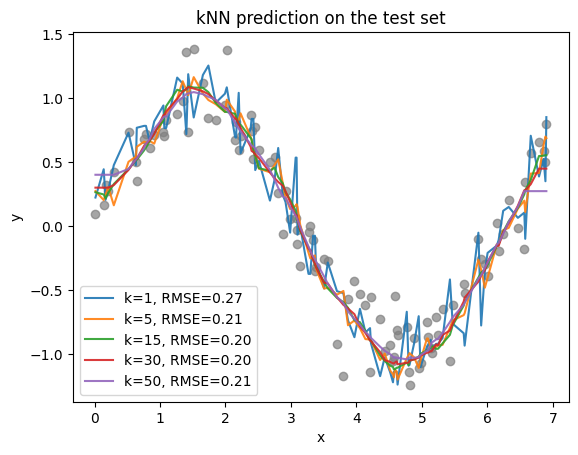

In [9]:
import numpy as np
np.random.seed(0)
n = 500
x = np.linspace(0, 7, n)
y_true = np.sin(x)
y = y_true + np.random.normal(0, 0.2, n)
X = x.reshape(-1, 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X_test, y_test, color="gray", alpha=0.7)
ax.set(xlabel="x", ylabel="y", title="kNN prediction on the test set")

from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

for k in [1, 5, 15, 30, 50]:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    rmse = root_mean_squared_error(y_pred, y_test)

    idx = np.argsort(X_test.flatten())
    x_test = np.sort(X_test.flatten())
    ax.plot(x_test, y_pred[idx], label=f"k={k}, RMSE={rmse:.2f}", alpha=0.9)

ax.legend()
fig.show()

各$k$についてkNN推定値を計算し、それらをつかって線形回帰して$k=0$を外挿してみる。

常にベストになるわけではなが、ほどほどに良い$k$を選んだときと同程度にはなるっぽい

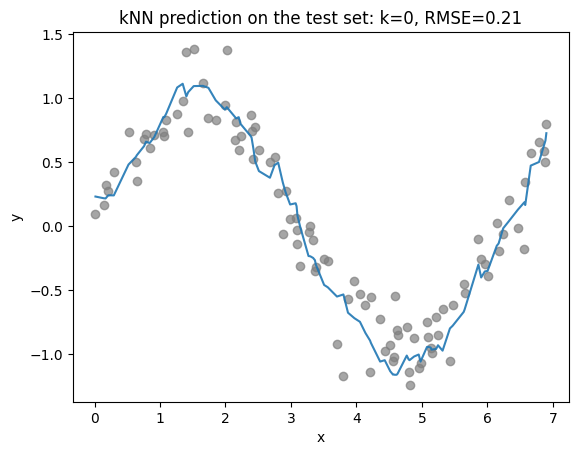

In [11]:
# fit
max_k = 50
models = {}
for k in range(1, max_k + 1):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    models[k] = knn

# predict
import statsmodels.api as sm
import statsmodels.formula.api as smf

y_preds = []
for i in range(X_test.shape[0]):
    preds = []
    for k in range(1, max_k + 1):
        y_pred = models[k].predict(X_test[[i]])[0]
        preds.append({"k": k, "y_pred": y_pred})
    preds = pd.DataFrame(preds)

    ols = smf.ols(formula='y_pred ~ k', data=sm.add_constant(preds)).fit()
    y_pred = ols.predict(pd.DataFrame([{"k": 0}]))[0]
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

# plot
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_preds, y_test)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X_test, y_test, color="gray", alpha=0.7)
ax.set(xlabel="x", ylabel="y", title=f"kNN prediction on the test set: k=0, RMSE={rmse:.2f}")

idx = np.argsort(X_test.flatten())
x_test = np.sort(X_test.flatten())
ax.plot(x_test, y_preds[idx], alpha=0.9)
fig.show()